In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

2023-05-20 19:08:12.401857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model

In [4]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [5]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  3,
"initial_collect_steps" :  30000,  # @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  2000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  5e-5,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : '2023-05-19--23:23:44', 
"conv_layer_params" : [(16,2,2), (32,2,2), (64,4,4), (128,2,2)],
"target_update_tau" :  1,
"target_update_period" :  10000,
"num_eval_episodes" :  200,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 51,  # @param {type:"integer"}
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 16, # @param {type:"integer"}
}

for key,val in all_params.items():
    exec(key + '=val')

In [6]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd, clairvoyante = clairvoyante)



2023-05-20 19:08:18.189576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:18.193389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:18.193609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/j

2023-05-20 19:08:22.166014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:22.166199: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-20 19:08:22.166312: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-20 19:08:22.166914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:22.167090: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-20 19:08:22.784595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:22.784798: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-20 19:08:22.784888: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-20 19:08:22.785139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:22.785306: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-05-20 19:08:25.930776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:25.930967: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-20 19:08:25.931057: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-20 19:08:25.931310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:25.931476: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-20 19:08:26.291884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:26.292092: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-20 19:08:26.292189: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-20 19:08:26.292485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 19:08:26.292663: I tensorflow/compiler/xla/stream_executor/

In [7]:
# Storage folder
if model_restore_path == None:
    rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
else:
    rl_session_name = model_restore_path
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
import json
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(all_params, f)
rl_session_name

'2023-05-19--23:23:44'

In [8]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [9]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-05-20 19:08:27.837591: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-05-20 19:08:27.837684: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-05-20 19:08:32.810368: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 4.5525001748465
Average error 27.560216676496115


Timer unit: 0.001 s

Total time: 72.2365 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 265

Line #      Hits         Time  Per Hit   % Time  Line Contents
   265                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   266       202          1.3      0.0      0.0  		state_history = self.state_history
   267       202          1.0      0.0      0.0  		city_ob = self.building_grid
   268       202          1.0      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   269       202          1.9      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   270                                           
   271                                           		# Swap columns at this point since
   272       202         23.7      0.1      0.0  		measured_coords = self.get_measured_coords()
   273                                           
   274                                  

In [10]:
# Q-network 
q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=51,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


In [11]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    epsilon_greedy=epsilon,
    categorical_q_network=q_net,
    optimizer=optimizer,
    n_step_update=n_step_update,
    boltzmann_temperature=boltzmann_temperature,
    gamma=gamma,
    min_q_value=0,
    max_q_value=max_q_value,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2023-05-20 19:09:40.435299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-05-20 19:09:40.984156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [13]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=10)

print((rand_reward, rand_pred_error))


(7.40625, 35.61559555377532)


In [14]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp2_ob_qev.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp2_ob_qev
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40095


In [15]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)


In [16]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)



In [17]:
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [18]:
best_reward = np.inf
num_eval_episodes = 100
losses = []
collect_rewards = []

In [19]:
for _ in range(1000000000):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(rew)

  step = agent.train_step_counter.numpy()

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (423642) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-05-20 19:18:44.311095: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f99b00340b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-20 19:18:44.311122: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-20 19:18:44.315028: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-20 19:18:44.424763: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


step = 2051000: loss = 2.2668750286102295,  rew = 0.026279296725988388
step = 2052000: loss = 2.3249988555908203,  rew = 0.033515624701976776
step = 2053000: loss = 2.267347812652588,  rew = 0.03691406175494194
step = 2054000: loss = 2.2264699935913086,  rew = 0.03621093928813934
step = 2055000: loss = 2.296147346496582,  rew = 0.03172851353883743
step = 2056000: loss = 2.2416136264801025,  rew = 0.021914063021540642
step = 2057000: loss = 2.298417568206787,  rew = 0.03984375298023224
step = 2058000: loss = 2.2583770751953125,  rew = 0.04233398288488388
step = 2059000: loss = 2.2585513591766357,  rew = 0.025517579168081284
step = 2060000: loss = 2.2649431228637695,  rew = 0.039521485567092896
step = 2061000: loss = 2.3902359008789062,  rew = 0.035244137048721313
step = 2062000: loss = 2.2470598220825195,  rew = 0.02988281287252903
step = 2063000: loss = 2.255948066711426,  rew = 0.033662110567092896
step = 2064000: loss = 2.3011977672576904,  rew = 0.031171875074505806
step = 2065000: 

In [ ]:
temp_schedule.temp = 0.0

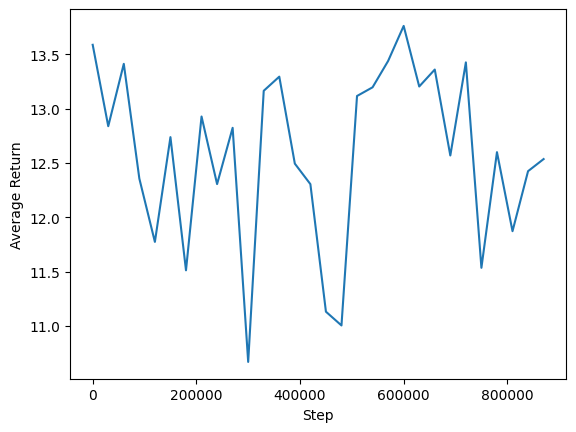

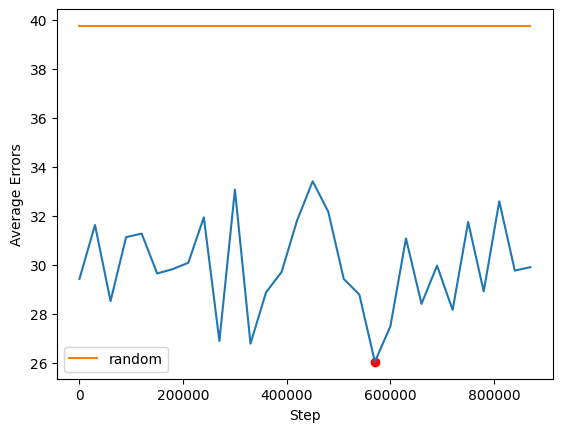

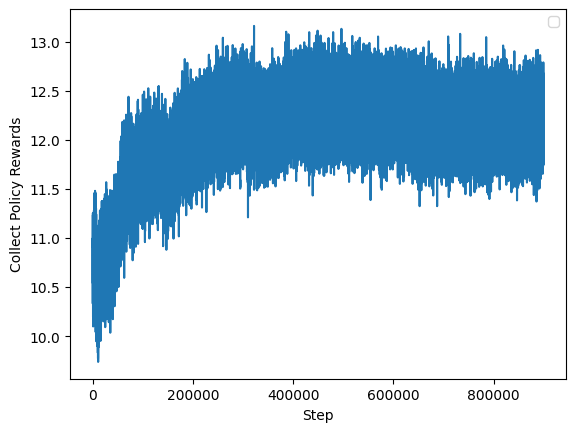

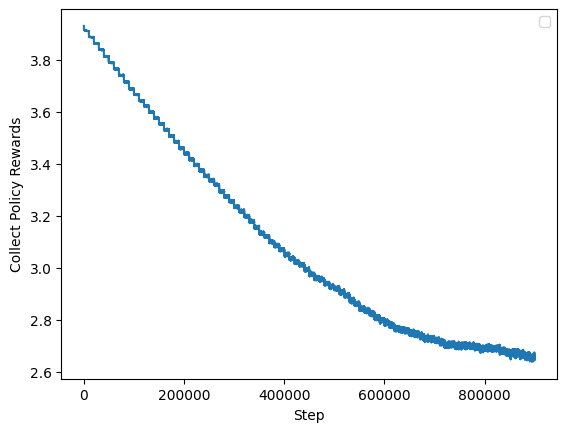

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/e

KeyboardInterrupt: 

In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

14.793147 25.72983358634253
